# FIT5202 Assignment 2A : Building models to predict future eCommerce sales

## Table of Contents
*  
    * [Part 1 : Data Loading, Transformation and Exploration](#part-1)
    * [Part 2 : Feature extraction and ML training](#part-2)
    * [Part 3 : Customer Segmentation and Knowledge sharing with K-Mean](#part-3)
    * [Part 4 : Data Ethics, Privacy, and Security](#part-4)

Please add code/markdown cells as you need.

# Part 1: Data Loading, Transformation and Exploration <a class="anchor" name="part-1"></a>
## 1.1 Data Loading
In this section, you will need to load the given datasets into PySpark DataFrames and use DataFrame functions to process the data. Usage of Spark SQL is discouraged, and your can only use pandas to format results. For plotting, different visualisation packages can be used, but please ensure that you have included instructions to install the additional packages and the installation will be successful in the provided docker container(in case your marker needs to clear the notebook and rerun it).

### 1.1.1 Data Loading <a class="anchor" name="1.1"></a>
Write the code to create a SparkSession. For creating the SparkSession, you need to use a SparkConf object to configure the Spark app with a proper application name, to ensure the maximum partition size not exceed 20MB, and to run locally with all CPU cores on your machine (note: if you have insufficient RAM, reducing the number of cores is also acceptable.)

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark import SparkContext

spark_conf = SparkConf().setAppName("Assignmnment2").set("spark.sql.files.maxPartitionBytes", "20m").setMaster("local[4]")

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

1.1.2 Write code to define the schemas for category, customer, product, clickstream and transaction datasets, following the data types suggested in the metadata file.

In [2]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType

category_schema = StructType([
    StructField("del", StringType(), True),
    StructField("category_id", IntegerType(), True),
    StructField("cat_level1", StringType(), True),
    StructField("cat_level2", StringType(), True),
    StructField("cat_level3", StringType(), True)
])

customer_schema = StructType([
    StructField("del", StringType(), True),
    StructField("customer_id", StringType(), True),
    StructField("first_name", StringType(), True),
    StructField("last_name", StringType(), True),
    StructField("username", StringType(), True),
    StructField("email", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("birthdate", StringType(), True), 
    StructField("device_type", StringType(), True),
    StructField("device_id", StringType(), True),
    StructField("device_version", StringType(), True),
    StructField("home_location_lat", FloatType(), True),
    StructField("home_location_long", FloatType(), True),
    StructField("home_location", StringType(), True),
    StructField("home_country", StringType(), True),
    StructField("first_join_date", StringType(), True)
])

product_schema = StructType([
    StructField("del", StringType(), True),
    StructField("id", IntegerType(), True),
    StructField("gender", StringType(), True),
    StructField("baseColour", StringType(), True),
    StructField("season", StringType(), True),
    StructField("year", IntegerType(), True),
    StructField("usage", StringType(), True),
    StructField("productDisplayName", StringType(), True),
    StructField("category_id", IntegerType(), True)
])

click_stream_schema = StructType([
    StructField("del", StringType(), True),
    StructField("session_id", StringType(), True),
    StructField("event_name", StringType(), True),
    StructField("event_time", TimestampType(), True),
    StructField("event_id", StringType(), True),
    StructField("traffic_source", StringType(), True),
    StructField("event_metadata", StringType(), True)
])

transaction_schema = StructType([
    StructField("del", StringType(), True),
    StructField("created_at", StringType(), True),
    StructField("customer_id", StringType(), True),
    StructField("booking_id", StringType(), True),
    StructField("session_id", StringType(), True),
    StructField("product_metadata", StringType(), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("promo_amount", FloatType(), True),
    StructField("promo_code", StringType(), True),
    StructField("shipment_fee", FloatType(), True),
    StructField("shipment_date_limit", StringType(), True),
    StructField("shipment_location_lat", FloatType(), True),
    StructField("shipment_location_long", FloatType(), True),
    StructField("total_amount", FloatType(), True)
])




1.1.3 Using predefined schema, write code to load the csv files into separate dataframes. Print the schemas of all dataframes.

In [3]:
category_df = spark.read.csv("category.csv", header=True, schema=category_schema)
customer_df = spark.read.csv("customer.csv", header=True, schema=customer_schema)
product_df = spark.read.csv("product.csv", header=True, schema=product_schema)
click_stream_df = spark.read.csv("click_stream.csv", header=True, schema=click_stream_schema)
transaction_df = spark.read.csv("new_transactions.csv", header=True, schema=transaction_schema)

In [4]:
category_df = category_df.drop("del")
customer_df = customer_df.drop("del")
product_df = product_df.drop("del")
click_stream_df = click_stream_df.drop("del")
transaction_df = transaction_df.drop("del")

In [5]:
category_df.printSchema()
customer_df.printSchema()
product_df.printSchema()
click_stream_df.printSchema()
transaction_df.printSchema()

root
 |-- category_id: integer (nullable = true)
 |-- cat_level1: string (nullable = true)
 |-- cat_level2: string (nullable = true)
 |-- cat_level3: string (nullable = true)

root
 |-- customer_id: string (nullable = true)
 |-- first_name: string (nullable = true)
 |-- last_name: string (nullable = true)
 |-- username: string (nullable = true)
 |-- email: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_version: string (nullable = true)
 |-- home_location_lat: float (nullable = true)
 |-- home_location_long: float (nullable = true)
 |-- home_location: string (nullable = true)
 |-- home_country: string (nullable = true)
 |-- first_join_date: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- baseColour: string (nullable = true)
 |-- season: string (nullable = true)
 |-- year: inte

### 1.2 Data Transformation to Create Features <a class="anchor" name="1.2"></a>
In the clickstream dataset, there are 9 types of events:  
VIEW_PROMO, SCROLL, ADD_PROMO, VIEW_ITEM, CLICK, PURCHASE, ADD_TO_CART, HOMEPAGE, SEARCH  
We categorize them into 3 different categories:  
Category 1(high value actions - highly likely to purchase): ADD_PROMO, ADD_TO_CART  
Category 2(medium value actions - likely to purchase): VIEW_PROMO, VIEW_ITEM, SEARCH  
Category 3(low value actions - just browsing):  SCROLL, HOMEPAGE, CLICK  
Perform the following tasks base on the clickstream dataframe and create a new dataframe.  

1.2.1 For each unique session_id, count the number of actions in each category and create 3 columns(num_cat_highvalue, num_cat_midvalue, num_cat_lowvalue).

In [6]:
click_stream_df.show(truncate=False)

+------------------------------------+-----------+--------------------------+------------------------------------+--------------+----------------------------------------------------------+
|session_id                          |event_name |event_time                |event_id                            |traffic_source|event_metadata                                            |
+------------------------------------+-----------+--------------------------+------------------------------------+--------------+----------------------------------------------------------+
|fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c|HOMEPAGE   |2019-09-06 15:54:32.821085|9c4388c4-c95b-4678-b5ca-e9cbc0734109|MOBILE        |null                                                      |
|fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c|SCROLL     |2019-09-06 16:03:57.821085|4690e1f5-3f99-42d3-84a5-22c4c4d8500a|MOBILE        |null                                                      |
|7d440441-e67a-4d36-b324-80ffd636d166|HOMEPAGE   |2019-

In [7]:
from pyspark.sql.functions import when, col, month

category_conditions = {
    "add_promo": (col("event_name") == "ADD_PROMO"),
    "num_cat_highvalue": (col("event_name") == "ADD_PROMO") | (col("event_name") == "ADD_TO_CART"),
    "num_cat_midvalue": (col("event_name") == "VIEW_PROMO") | (col("event_name") == "VIEW_ITEM") | (col("event_name") == "SEARCH"),
    "num_cat_lowvalue": (col("event_name") == "SCROLL") | (col("event_name") == "HOMEPAGE") | (col("event_name") == "CLICK")
}

In [8]:
click_stream_df = click_stream_df.withColumn("event_month", month(col("event_time")))

In [9]:
from pyspark.sql import functions as F

for category_name, condition in category_conditions.items():
    click_stream_df = click_stream_df.withColumn(category_name, when(condition, 1).otherwise(0))

feature_df = click_stream_df.groupBy("session_id").agg(
    F.sum("add_promo").alias("add_promo"),
    F.sum("num_cat_highvalue").alias("num_cat_highvalue"),
    F.sum("num_cat_midvalue").alias("num_cat_midvalue"),
    F.sum("num_cat_lowvalue").alias("num_cat_lowvalue"),
    F.max("event_month").alias("event_month")
)
feature_df.show(truncate=False)

+------------------------------------+---------+-----------------+----------------+----------------+-----------+
|session_id                          |add_promo|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|event_month|
+------------------------------------+---------+-----------------+----------------+----------------+-----------+
|2fdb7762-98d5-4324-ba49-e71164b44ff9|0        |1                |2               |2               |4          |
|e7f689a1-28a0-4fe7-9e12-c40f9fcc9b0f|0        |1                |1               |3               |4          |
|2faff3e1-25cf-438f-a81e-4f0c5878bc4e|1        |2                |6               |13              |9          |
|3f2d99e1-51ff-402a-a831-02f3c68cbc39|0        |1                |0               |2               |3          |
|5386d3f4-98ea-448c-bdf3-88d55877fc52|1        |2                |9               |18              |12         |
|30f85513-ceae-4527-b59f-a4b79a6ed2ab|0        |1                |2               |2            

1.2.2. Create 2 columns with percentage ratio of high value action and low value actions. (i.e. high value ratio = (count of high value actions)/(total actions) * 100%)

In [10]:
feature_df = feature_df.withColumn("total_actions", col("num_cat_highvalue") + col("num_cat_midvalue") + col("num_cat_lowvalue"))
feature_df = feature_df.withColumn("high_value_ratio", (col("num_cat_highvalue") / col("total_actions")) * 100)
feature_df = feature_df.withColumn("low_value_ratio", (col("num_cat_lowvalue") / col("total_actions")) * 100)
feature_df.show()

+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+
|          session_id|add_promo|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|event_month|total_actions|  high_value_ratio|   low_value_ratio|
+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+
|2fdb7762-98d5-432...|        0|                1|               2|               2|          4|            5|              20.0|              40.0|
|e7f689a1-28a0-4fe...|        0|                1|               1|               3|          4|            5|              20.0|              60.0|
|2faff3e1-25cf-438...|        1|                2|               6|              13|          9|           21| 9.523809523809524|61.904761904761905|
|3f2d99e1-51ff-402...|        0|                1|               0|               2|          3|          

1.2.3 Create a new column “is_promotion” with value of 1 or 0 and add to feature_df. If there are “ADD_PROMO” actions in a session, set it to 1, otherwise 0.

In [11]:
feature_df = feature_df.withColumn("is_promotion", when(col("add_promo") > 0, 1).otherwise(0))
feature_df.show()

+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+------------+
|          session_id|add_promo|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|event_month|total_actions|  high_value_ratio|   low_value_ratio|is_promotion|
+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+------------+
|2fdb7762-98d5-432...|        0|                1|               2|               2|          4|            5|              20.0|              40.0|           0|
|e7f689a1-28a0-4fe...|        0|                1|               1|               3|          4|            5|              20.0|              60.0|           0|
|2faff3e1-25cf-438...|        1|                2|               6|              13|          9|           21| 9.523809523809524|61.904761904761905|           1|
|3f2d99e1-51ff-402...|      

1.2.4 For each unique session_id, base on event_time, extract the season. (note: The dataset is from Indonesia, Spring: Mar-May, Summer: Jun-Aug, Autumn: Sep-Nov, Winter: Dec-Feb)

In [12]:
from pyspark.sql.functions import to_timestamp, month, when,udf
def map_to_season1(month):
    if month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    elif month in [9, 10, 11]:
        return "Autumn"
    else:
        return "Winter"
map_to_season = udf(lambda z: map_to_season1(z))
feature_df = feature_df.withColumn("season", when(col("event_month").isNotNull(), map_to_season(col("event_month"))).otherwise(None))
feature_df.show()

+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+------------+------+
|          session_id|add_promo|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|event_month|total_actions|  high_value_ratio|   low_value_ratio|is_promotion|season|
+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+------------+------+
|2fdb7762-98d5-432...|        0|                1|               2|               2|          4|            5|              20.0|              40.0|           0|Spring|
|e7f689a1-28a0-4fe...|        0|                1|               1|               3|          4|            5|              20.0|              60.0|           0|Spring|
|2faff3e1-25cf-438...|        1|                2|               6|              13|          9|           21| 9.523809523809524|61.904761904761905|       

1.2.5 Join tables to find customer information and add columns to feature_df: gender, age, device type, home_location, first join year. (note: For some column, you need to perform transformation. For age, keep integer only.)

In [13]:
from pyspark.sql.functions import year,current_date
joined_df1 = feature_df.join(transaction_df, "session_id", "inner")
joined_df = joined_df1.join(customer_df, "customer_id", "inner")
joined_df = joined_df.withColumn("age", year(current_date()) - year(col("birthdate")))
joined_df = joined_df.withColumn("first_join_year", year(col("first_join_date")))
customer_info_columns = ["customer_id", "gender", "device_type", "home_location", "first_join_year","age"]
feature_df = joined_df.select(*(feature_df.columns + customer_info_columns))
feature_df.show()

+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+------------+------+-----------+------+-----------+--------------+---------------+---+
|          session_id|add_promo|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|event_month|total_actions|  high_value_ratio|   low_value_ratio|is_promotion|season|customer_id|gender|device_type| home_location|first_join_year|age|
+--------------------+---------+-----------------+----------------+----------------+-----------+-------------+------------------+------------------+------------+------+-----------+------+-----------+--------------+---------------+---+
|0bad921c-cb17-489...|        0|                1|               8|              42|          8|           51|1.9607843137254901| 82.35294117647058|           0|Summer|      10000|     M|    Android|   Jawa Tengah|           2021| 18|
|b91fb12f-63d7-4ab...|        1|                8|          

1.2.6 Join tables to find out if the customer made purchase or not, and add to feature_df as 1 or 0. We will use this column as training label later.

In [14]:
joined_df = feature_df.join(transaction_df, "session_id", "inner")
joined_df = joined_df.withColumn("purchase_status", when(col("payment_status")  == "Success", 1).otherwise(0))
feature_df = joined_df.select("session_id", "num_cat_highvalue", "num_cat_midvalue", "num_cat_lowvalue", "high_value_ratio", "low_value_ratio", "is_promotion","season", "gender", "age", "device_type", "home_location", "first_join_year", "purchase_status")
feature_df.show()

+--------------------+-----------------+----------------+----------------+------------------+------------------+------------+------+------+---+-----------+-------------------+---------------+---------------+
|          session_id|num_cat_highvalue|num_cat_midvalue|num_cat_lowvalue|  high_value_ratio|   low_value_ratio|is_promotion|season|gender|age|device_type|      home_location|first_join_year|purchase_status|
+--------------------+-----------------+----------------+----------------+------------------+------------------+------------+------+------+---+-----------+-------------------+---------------+---------------+
|00005746-17ec-449...|                1|              20|              44|1.5384615384615385|  67.6923076923077|           0|Spring|     M| 21|    Android|       Jakarta Raya|           2020|              0|
|0000a729-3de3-461...|                2|               0|               2|              50.0|              50.0|           0|Spring|     M| 18|    Android|       Jakart

### 1.3 Exploring the Data <a class="anchor" name="1.3"></a>
**1.3.1 With the feature_df, write code to show the basic statistics: a) For each numeric column, show count, mean, stddev, min, max, 25 percentile, 50 percentile, 75 percentile; b)For each non-numeric column, display the top-5 values and the corresponding counts; c) For each boolean column, display the value and count.**

In [15]:
numeric_stats = feature_df.select("num_cat_highvalue", "num_cat_midvalue", "num_cat_lowvalue", "high_value_ratio", "low_value_ratio", "age", "first_join_year").summary()
numeric_stats.show()

non_numeric_columns = ["session_id", "gender", "device_type", "home_location","season"]
for column in non_numeric_columns:
    non_numeric_stats = feature_df.groupBy(column).count().orderBy(col("count").desc())
    print(f"Top 5 values and counts for column '{column}':")
    non_numeric_stats.show(5)

boolean_columns = ["is_promotion","purchase_status"]
for column in boolean_columns:
    boolean_stats = feature_df.groupBy(column).count()
    print(f"Value and count for boolean column '{column}':")
    boolean_stats.show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|summary| num_cat_highvalue|  num_cat_midvalue| num_cat_lowvalue|  high_value_ratio|   low_value_ratio|               age|   first_join_year|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+
|  count|            852582|            852582|           852582|            852582|            852582|            852582|            852582|
|   mean|2.6051054326739247|3.4767916751702477|7.536056355869582|  26.8371588826945|51.904517056564174|27.397053890417578| 2018.674827758503|
| stddev|2.3019669452150615| 4.517714508936985|9.364566759935979|17.369969954690383| 16.10473358964654|7.2859722210688735|1.6759156622858395|
|    min|                 1|                 0|                1|0.2074688796680498|1.8181818181818181|                 7|              2016|
|    2

**1.3.2 Explore the dataframe and write code to present two plots worthy of presentation to the company, describe your plots and discuss the findings from the plots.**
- One of the plots needs to base on feature_df, you’re free to choose the other one.  
- Hint: you can use the basic plots (e.g., histograms, line charts, scatter plots) for the relationship between a column and the label; or more advanced plots like correlation plots; 2: if your data is too large for the plotting, consider using sampling before plotting.  
- 150 words max for each plot’s description and discussion  
- Feel free to use any plotting libraries: matplotlib, seabon, plotly, etc.  
- Please only use the provided data for visualisation  


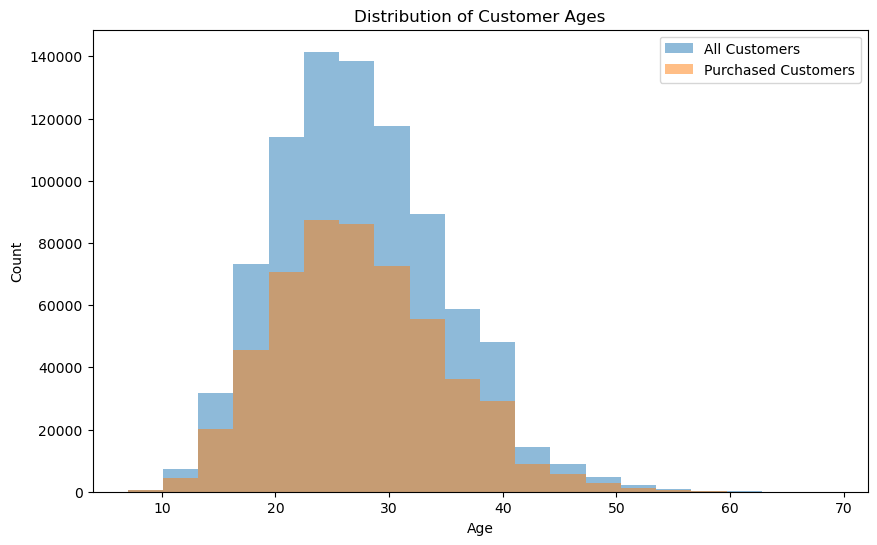

In [16]:
import matplotlib.pyplot as plt
purchased_customers = feature_df.filter(col("purchase_status") == 1)
plt.figure(figsize=(10, 6))
plt.hist(feature_df.select("age").rdd.flatMap(lambda x: x).collect(), bins=20, alpha=0.5, label="All Customers")
plt.hist(purchased_customers.select("age").rdd.flatMap(lambda x: x).collect(), bins=20, alpha=0.5, label="Purchased Customers")
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Customer Ages")
plt.legend(loc="upper right")
plt.show()

We create a histogram to explore the distribution of customer ages (from the feature_df) and its relationship with the purchase status. This histogram plot displays the distribution of customer ages in two groups which are all customers and customers who made a purchase. The x-axis represents the age while the y axis represents the count of the customers. Here we can see the age range of the customers who have the most sessions. Also by comparing the two groups we can observe whether there are any significant differences in age distribution between customers who made a purchase and the overall customer base. However the plots shows us that there are no such tread here. Also we see that the customers in the range of 20-28 have the most sessions peaking at around 22-25.


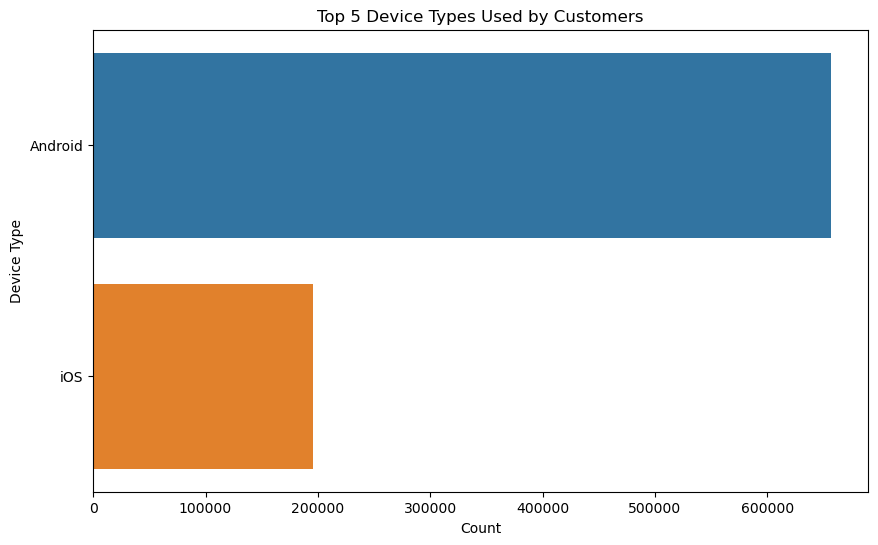

In [17]:
import seaborn as sns
top_device_types = feature_df.groupBy("device_type").count().orderBy("count", ascending=False).limit(5)
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="device_type", data=top_device_types.toPandas(), orient="h")
plt.xlabel("Count")
plt.ylabel("Device Type")
plt.title("Top 5 Device Types Used by Customers")
plt.show()

For the second plot we create a bar chart to visualize the top 5 device types used by customers. This bar chart provides insight into the top 5 device types used by customers. The x-axis represents the count of customers and the y-axis represents different device types. This can help the company to understand the most prevalent devices among its customer base. This information can be valuable for optimizing the user experience and ensuring that the company's services are accessible on the most commonly used devices. Here we see that most of the customers use an android device as compared to an ios and so the company can priotize working on optimizing or creating an android application instead of an ios application as an example.


## Part 2. Feature extraction and ML training <a class="anchor" name="part-2"></a>
In this section, you will need to use PySpark DataFrame functions and ML packages for data preparation, model building, and evaluation. Other ML packages, such as scikit-learn, would receive zero marks. Excessive usage of Spark SQL is discouraged.
### 2.1 Discuss the feature selection and prepare the feature columns

2.1.1 Based on the data exploration from 1.2 and considering the situation we have, discuss the importance of those features (For example, which features may be useless and should be removed, which feature has a great impact on the label column, which should be transformed) which features you are planning to use? Discuss the reasons for selecting them and how you create/transform them
- 300 words max for the discussion
- Please only use the provided data for model building
- You can create/add additional feature/column based on the dataset
- Hint - things to consider include whether to create more feature columns, whether to remove some columns, using the insights from the data exploration/domain knowledge/statistical models  

In building a predictive model feature selection plays a critical role in determining the model's accuracy and effectiveness. Considering the companies case study we can discuss the importance of the following features in the dataset:
1. Age: Age is likely to be an important feature as it can provide valuable insights into the customer’s behaviour. Younger customers may have different preferences and purchase patterns compared to older customers. This feature should be retained and used as is.
2. Device Type: The type of device used by customers could significantly impact their interaction with the platform. Android users might have different behaviours compared to apple users. This categorical feature is important and should be one-hot encoded for model training.
3. Gender: Gender is another categorical feature that can influence purchase decisions. It's important to include it in the model and one-hot encoding can be applied for modelling.
4. Is_Promotion: The is_promotion column indicates whether a promotion was added during the session could be a strong indicator of purchase behaviour as it probably may lead to more chances of a success payment. This binary feature should be retained as is.
5. High Value, Mid Value and Low Value Counts: The counts of high-value and low-value actions can be crucial in understanding the level of customer engagement. They provide valuable context and should be included in the model.
6. First Join Year: The year when a customer first joined the platform might indicate customer loyalty or engagement duration. This feature should be retained and used as is.
7. Home Location: Home location may or may not have a significant impact on purchase behaviour. It might impact if people from richer locations are more likely to make purchases. It is a categorical value and should be one-hot encoded.
8. Season:  The season can be an important temporal feature. Seasonal trends can influence purchase decisions. This feature should be retained and one-hot encoded.

2.1.2 Write code to create/transform the columns based on your discussion above
- Hint: You can use one dataframe for both two use cases(classification and k-mean later in part 3) since you can select your desired columns as the input and output for each use case.


In [18]:
from pyspark.ml.feature import StringIndexer 
from pyspark.ml.feature import OneHotEncoder
category_input = ['season', 'gender', 'device_type', 'home_location']
numeric_input = ['num_cat_highvalue', 'num_cat_lowvalue', 'num_cat_midvalue', 'high_value_ratio','is_promotion','low_value_ratio', 'first_join_year', 'age']
catergory_output = 'purchase_status'
category_column = category_input + [catergory_output]
outputCols=[f'{x}_index' for x in category_input]
outputCols.append('label')
indexer = StringIndexer(inputCols=category_column,outputCols=outputCols)
inputCols_OHE = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in category_input]
encoder = OneHotEncoder(inputCols=inputCols_OHE,outputCols=outputCols_OHE)

### 2.2 Preparing Spark ML Transformers/Estimators for features, labels, and models  <a class="anchor" name="2.2"></a>

**2.2.1 Write code to create Transformers/Estimators for transforming/assembling the columns you selected above in 2.1, and create ML model Estimators for Random Forest (RF) and Gradient-boosted tree (GBT) model.
Please DO NOT fit/transform the data yet**

In [19]:
from pyspark.ml.linalg import Vectors
from sklearn.metrics import roc_curve, auc
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

inputCols= outputCols_OHE
assembler_inputs = inputCols + numeric_input
assembler = VectorAssembler(inputCols = assembler_inputs, outputCol="features")
rf_estimator = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
gbt_estimator = GBTClassifier(featuresCol='features', labelCol='label', maxDepth=3)

**2.2.2. Write code to include the above Transformers/Estimators into two pipelines.
Please DO NOT fit/transform the data yet**

In [20]:
stage_1 = indexer
stage_2 = encoder
stage_3 = assembler
stage_4 = rf_estimator
stages = [stage_1, stage_2, stage_3,stage_4]
rfpipeline = Pipeline(stages = stages)

In [21]:
stage_4 = gbt_estimator
stages = [stage_1, stage_2, stage_3,stage_4]
gbtpipeline = Pipeline(stages = stages)

### 2.3 Preparing the training data and testing data  
Write code to split the data for training and testing purposes.  
Note: Due to the large size of the dataset, you can choose to use random sampling (say 20% of the dataset) and do a train/test split; or use one year of data for training and another year for testing.

In [22]:
test_fraction = 0.2
dfs = feature_df.sample(fraction=test_fraction)
train, test = dfs.randomSplit([1 - test_fraction, test_fraction])
print("Training Dataset Count: " + str(train.count ( )))
print("Test Dataset Count: " + str(test.count( )))

Training Dataset Count: 136305
Test Dataset Count: 34023


### 2.4 Training and evaluating models  
2.4.1 Write code to use the corresponding ML Pipelines to train the models on the training data from 2.3. And then use the trained models to predict the testing data from 2.3

In [42]:
rfmodel=rfpipeline.fit(train)
rfpredictions=rfmodel.transform(test)
trainingSummary = rfmodel.stages[-1].summary

In [24]:
TN=rfpredictions.filter('prediction = 0 AND label = 0').count()
TP=rfpredictions.filter('prediction = 1 AND label = 1').count()
FN=rfpredictions.filter('prediction = 0 AND label = 1').count()
FP=rfpredictions.filter('prediction = 1 AND label = 0').count()
rfpredictions.groupBy('label', 'prediction').count().show()
accuracy = (TP + TN)/(TP + TN + FN +FP)
precision = (TP )/(TP +FP)
recall = (TP )/(TP +FN)
f1 = (2/((1/recall) + (1/precision)))
print('accuracy:',accuracy)
print('f1:',f1)
print('precision:',precision)
print('recall:',recall)
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 5367|
|  0.0|       1.0|   38|
|  1.0|       0.0| 7464|
|  0.0|       0.0|21154|
+-----+----------+-----+

accuracy: 0.7795021015195603
f1: 0.5886159245448563
precision: 0.9929694727104533
recall: 0.4182838438157587
TP: 5367
TN: 21154
FP: 38
FN: 7464


Area Under ROC: 0.8487234125667534


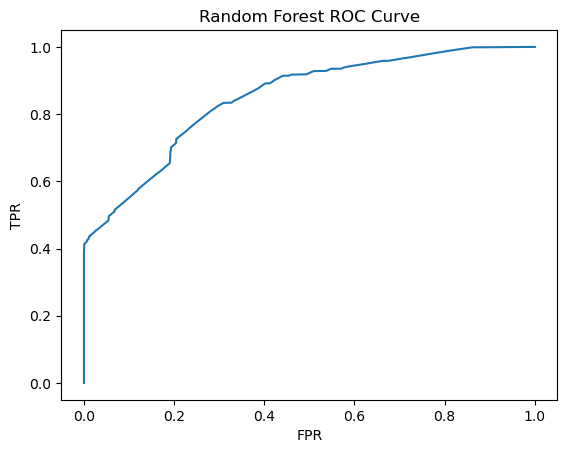

In [40]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Area Under ROC: " + str(evaluator.evaluate(rfpredictions, {evaluator.metricName: "areaUnderROC"})))
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.title('Random Forest ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [43]:
gbtmodel=gbtpipeline.fit(train)
gbtpredictions=gbtmodel.transform(test)

In [28]:
TN = gbtpredictions.filter('prediction = 0 AND label = 0').count()
TP = gbtpredictions.filter('prediction = 1 AND label = 1').count()
FN = gbtpredictions.filter('prediction = 0 AND label = 1').count()
FP = gbtpredictions.filter('prediction = 1 AND label = 0').count()
gbtpredictions.groupBy('label', 'prediction').count().show()
accuracy = (TP + TN)/(TP + TN + FN +FP)
precision = (TP )/(TP +FP)
recall = (TP )/(TP +FN)
f1 = (2/((1/recall) + (1/precision)))
print('accuracy:',accuracy)
print('f1:',f1)
print('precision:',precision)
print('recall:',recall)
print('TP:',TP)
print('TN:',TN)
print('FP:',FP)
print('FN:',FN)

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 6499|
|  0.0|       1.0|   28|
|  1.0|       0.0| 6332|
|  0.0|       0.0|21164|
+-----+----------+-----+

accuracy: 0.813067630720395
f1: 0.6714536625684472
precision: 0.9957101271640877
recall: 0.5065076767204427
TP: 6499
TN: 21164
FP: 28
FN: 6332


Area Under ROC: 0.8708589821996727


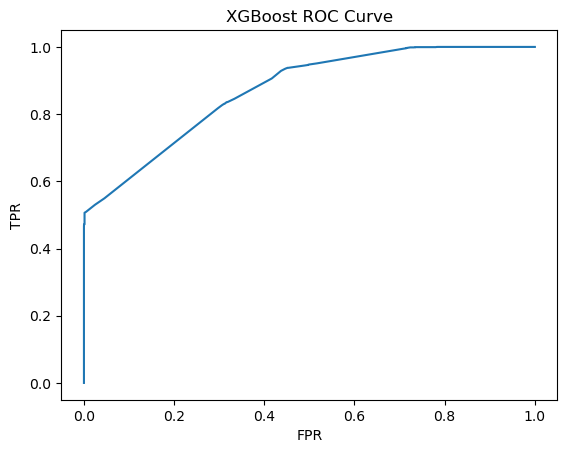

In [41]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
print("Area Under ROC: " + str(evaluator.evaluate(gbtpredictions, {evaluator.metricName: "areaUnderROC"})))
pred=gbtpredictions.select("label", "probability").toPandas()
fpr,tpr,_=roc_curve(pred["label"],pred["probability"].apply(lambda y: y[1]))
plt.plot(fpr,tpr)
plt.title('XGBoost ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

2.4.2 For both models(RF and GBT) and testing data, write code to display the count of TP/TN/FP/FN. Compute the AUC, accuracy, recall, and precision for the above-threshold/below-threshold label from each model testing result using pyspark MLlib/ML APIs.
- Draw a ROC plot.
- Discuss which one is the better model(no word limit, please keep it concise)

We can compare the AUC, accuracy, recall, precision, and ROC curves of both models to determine which one performs better for your specific classification task. Random Forest has an AUC of 0.84 which is lower than XGboost. Also has lower scores of accuracy, recall, and precision. While XGboost has an AUC of 0.87 and performs much better. Also XGBoost is known for its computational efficiency and often trains faster than Random Forest. It also has an advantage due to its parallelization capabilities and hence is more scalable. For these reasons we choose XGboost.

2.4.3 Save the better model, we will need this for Part B of assignment 2.  
(note: You may need to go through a few training loops or use more data to create a better-performing model.)

In [32]:
gbtmodel.save("better2")

### Part 3. Customer Segmentation and Knowledge sharing with K-Mean <a class="anchor" name="part-3"></a>  
Please see the specification for this task and add code/markdown cells.

In [33]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [37]:
kmean_data=transaction_df.select("session_id","customer_id").join(feature_df,"session_id",'inner')
kmean_data=kmean_data.select('session_id','customer_id','age','season')
cf=customer_df.join(kmean_data,"customer_id",'inner')
cf2=cf.groupBy('customer_id','season','device_type','home_location').agg(F.avg('age').alias('age'))
inputcols1=['season','device_type','home_location']
outputcols1=['season_x','device_type_x','home_location_x']
num=['age']
indexer=StringIndexer(inputCols=inputcols1, outputCols=outputcols1)
OHEcols=['season_OHE','device_type_OHE','home_location_OHE']
encoder=OneHotEncoder(inputCols=outputcols1,outputCols=OHEcols)
ai=OHEcols+num
assembler=VectorAssembler(inputCols=ai,outputCol="features")

In [38]:
cf1 =cf2.sample(fraction=.2)

In [39]:
evaluator = ClusteringEvaluator()
silhouette_arr=[]
for k in range(2,10):
    k_means= KMeans(featuresCol='features', k=k)
    stages=[indexer,encoder,assembler,k_means]
    kpipeline = Pipeline(stages=stages)
    model = kpipeline.fit(cf1)
    predictions = model.transform(cf1)
    silhouette = evaluator.evaluate(predictions)
    silhouette_arr.append(silhouette)
    print('No of clusters:',k,'Silhouette Score:',silhouette)

No of clusters: 2 Silhouette Score: 0.6871482581878334
No of clusters: 3 Silhouette Score: 0.6468085872854336
No of clusters: 4 Silhouette Score: 0.617043537570798
No of clusters: 5 Silhouette Score: 0.5992944863831153
No of clusters: 6 Silhouette Score: 0.5822526412467308
No of clusters: 7 Silhouette Score: 0.5671303296679102
No of clusters: 8 Silhouette Score: 0.5113672974582337
No of clusters: 9 Silhouette Score: 0.4929274804598785


As we get the best silhouette scores for just two clusters, we will segment our customer base into two categories depending on the season, age, geographical location and OS preferences. By segmenting customers into these two clusters derived from the K-means model the retailer can enhance its marketing strategies. Cluster 1 should be approached with flexibility and variety. This cluster represents customers with a wide range of characteristics including varying geographical locations, device preferences, ages and seasons. For this group it is essential to adopt a versatile marketing approach. While Cluster 2 should receive personalized and highly targeted marketing initiatives. This group is ideal for a more focused marketing approach. To effectively engage with them the retailer should craft highly targeted marketing campaigns, product recommendations and promotions that align with their specific characteristics and preferences. Specialized loyalty programs, personalized product suggestions and exclusive offers that cater to the preferences and shopping habits of this cluster can drive higher conversion rates and customer retention. Continuously monitoring customer data and adjusting strategies based on evolving trends and preferences will be crucial for long-term success in both segments.

### Part 4: Data Ethics, Privacy, and Security <a class="anchor" name="part-4"></a>  
Please see the specification for this task and add markdown cells(word limit: 500).

1. Data Ethics: Data ethics play a pivotal role in shaping the responsible use of big data. Ethical considerations include fairness, transparency, accountability and ensuring that data driven decisions benefit the society. Failure to uphold these principles can lead to negative consequences. For instance, the misuse of customer data by companies like Cambridge Analytica which exploited personal information for political purposes, highlighted the need for stricter ethical standards in big data processing. Positive examples of data ethics include companies that anonymize and aggregate customer data to protect individual privacy while still deriving valuable insights. Ethical data practices are not just a moral obligation but also contribute to building trust among customers and fostering long term relationships. Technological advancements should align with ethical responsibilities. As we develop more powerful data processing tools ethical considerations should guide their use while ensuring they are not exploited for unethical purposes. 
2. Data Privacy: Maintaining privacy in big data is difficult due to the huge volume of data collected and processed. Data privacy is important because individuals have a right to control their personal information. Regulations like the General Data Protection Regulation in the European Union state the importance of obtaining informed consent and  providing data access rights and notifying individuals about data breaches. To ensure privacy organizations should implement techniques like data anonymization and differential privacy. Improvements can include refining anonymization methods to protect against re-identification attacks and developing more user-friendly consent mechanisms.
3. Data Security: Security is really important in big data processing. With large datasets there are increased security risks such as data breaches and cyberattacks. Measures like encryption and authentication are crucial for safeguarding data. Organizations should also implement intrusion detection systems and conduct regular security audits. The potential security risks associated with big data processing are quite diverse ranging from unauthorized access to data manipulation. These risks may lead to severe consequences like financial losses or damage to an organization's reputation.

Key Findings and Summary:
1. Data ethics are essential in guiding the responsible use of big data, ensuring fairness, transparency and accountability. 
2. Privacy in big data is a complex issue that requires compliance with regulations like GDPR and the development of improved privacy preserving techniques.
3. Data security measures such as encryption and access controls are critical for protecting against security risks. 
Ethical considerations should be integrated into technological advancements to prevent unethical use of data

## References:
Please add your references below:

1. Mittelstadt, B. D., Allo, P., Taddeo, M., Wachter, S., & Floridi, L. (2016). The ethics of algorithms: Mapping the debate. Big Data & Society, 3(2), 2053951716679679.
2. Solove, D. J. (2006). A taxonomy of privacy. University of Pennsylvania Law Review, 154(3), 477-560.
3. Choo, K. K. R. (2011). Cybersecurity: Managing systems, conducting testing, and investigating intrusions. Jones & Bartlett Learning.
4. https://spark.apache.org/docs/latest/sql-data-sources-csv.html
5. https://import-as.github.io/import/pyspark.sql.functions.html
6. https://stackoverflow.com/questions/48282321/valueerror-cannot-convert-column-into-bool
7. https://sparkbyexamples.com/pyspark/pyspark-printschema-example/
8. https://sparkbyexamples.com/pyspark/pyspark-apply-function-to-column/
9. https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
10. https://sparkbyexamples.com/pyspark/pyspark-where-filter/
11. https://sparkbyexamples.com/pyspark/pyspark-current-date-timestamp/
12. https://sparkbyexamples.com/pyspark/pyspark-isnull/#:~:text=PySpark%20isNotNull(),-pyspark.text=sql.-,Column.,is%20no%20equivalent%20in%20sql.
13. https://www.machinelearningplus.com/pyspark/pyspark-statistics-deciles-and-quartiles/
14. https://stackoverflow.com/questions/50793165/pyspark-how-are-dataframe-describe-and-summary-implemented/50794458#50794458
15. https://www.kaggle.com/code/tientd95/advanced-pyspark-for-exploratory-data-analysis